In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
keras version 2.12.0
tensorflow version 2.12.0


In [2]:
## The location of the Flickr8K_ images
dir_Flickr_jpg = "/content/drive/MyDrive/ImageCaption/Flicker8k_Dataset/"
## The location of the caption file
dir_Flickr_text = "/content/drive/MyDrive/ImageCaption/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [33]:
#Finding the captions for each image.
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


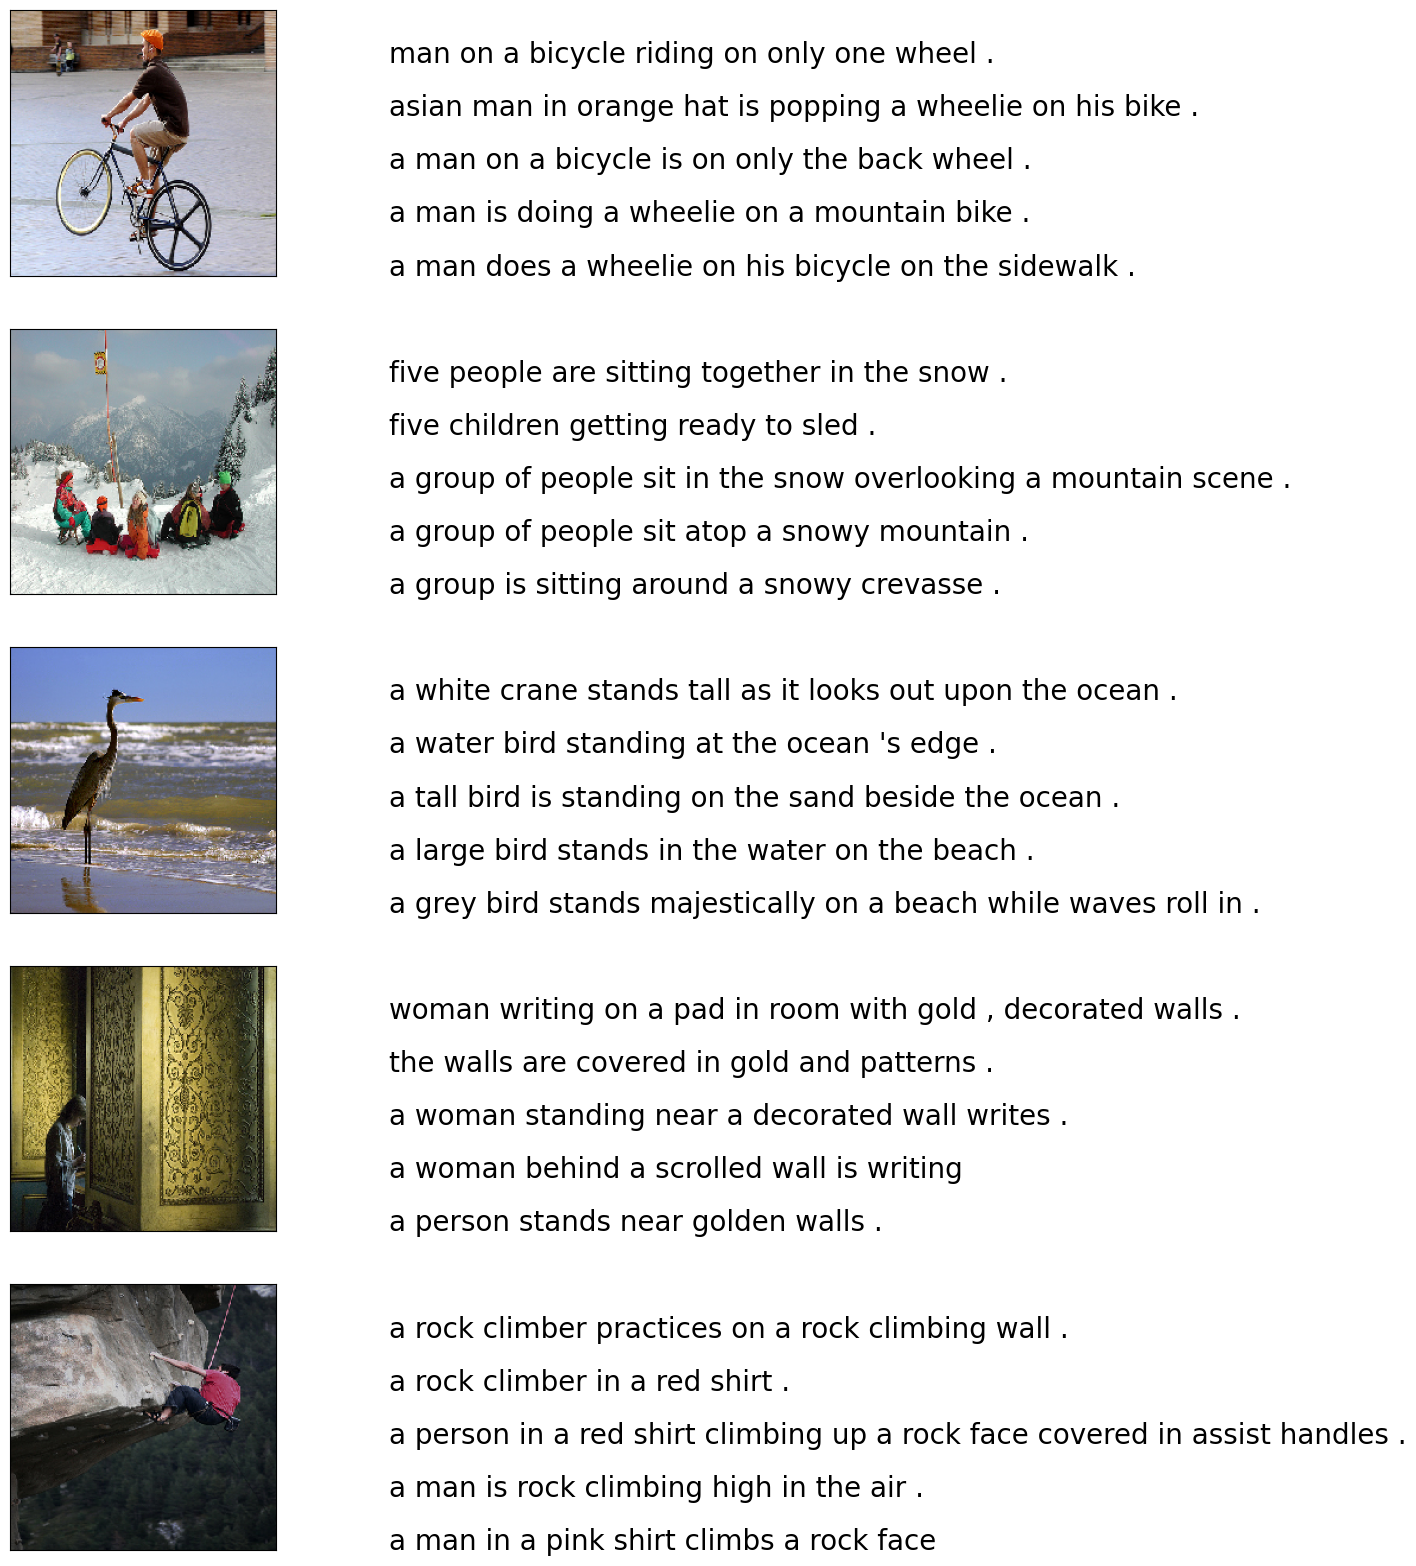

In [34]:
from tensorflow.keras.utils import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 5 # Displaying 5 images from the dataset
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [35]:
# Defining a function to calculate the top 3 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


In [36]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v27 Its 230 pm Could you buy me iphone7

Remove words with numeric values..
    ate        : True
    1000       : False
    apples     : True
    and        : True
    banana     : True
    have       : True
    python     : True
    v27        : False
    Its        : True
    230        : False
    pm         : True
    Could      : True
    you        : True
    buy        : True
    me         : True
    iphone7    : False
 ate apples and banana have python Its pm Could you buy me


In [37]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

In [38]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [39]:
df_txt0[:5]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...


In [41]:
df_txt0.to_csv('df2.csv',index=False)

In [10]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights 
modelvgg.load_weights("/content/drive/MyDrive/ImageCaption/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224 #image size is fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

In [ ]:
import pickle

# Save images as a pickle file
with open('images.pickle', 'wb') as handle:
    pickle.dump(images, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [12]:
import pickle

# Load images from the saved pickle file
with open('/content/drive/MyDrive/ImageCaption/images.pickle', 'rb') as handle:
    images = pickle.load(handle)


In [13]:
from sklearn.decomposition import PCA

encoder = np.array(list(images.values()))
#print(encoder)
pca = PCA(n_components=2)
#print(pca)
y_pca = pca.fit_transform(encoder)

In [ ]:
images

In [60]:
dimages, keepindex = [],[]
# Creating a datframe where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        print(dimages)
        keepindex.append(i)

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)

Output hidden; open in https://colab.research.google.com to view.

In [59]:
dimages

[array([6.59256830e-06, 2.28638091e-05, 4.82471660e-06, 3.32490089e-07,
        1.05137315e-06, 1.60326124e-06, 6.32631497e-07, 5.84116278e-05,
        1.11605594e-04, 1.64872370e-06, 5.00343731e-06, 9.20924413e-06,
        6.84242113e-05, 4.22899257e-06, 2.44628493e-04, 6.13135671e-06,
        3.95039109e-07, 1.37282783e-04, 6.73728664e-06, 1.08210797e-05,
        1.23095924e-06, 6.12573160e-07, 4.88873548e-06, 2.69399311e-06,
        6.93885113e-06, 4.77851790e-06, 1.32939476e-06, 2.83973372e-06,
        1.31584920e-06, 1.53051815e-06, 8.45711747e-06, 2.49206414e-06,
        2.35958510e-06, 1.99455644e-06, 6.19540458e-07, 1.94407062e-06,
        1.00268015e-04, 5.31843398e-05, 8.04968749e-07, 3.57211975e-05,
        1.26836369e-06, 1.59052956e-06, 1.62830236e-06, 3.39975054e-06,
        1.41583007e-06, 2.60991164e-05, 4.57735632e-06, 2.48051293e-07,
        3.96576979e-05, 1.05053477e-05, 1.31078996e-05, 4.21681980e-05,
        5.45701459e-06, 8.41048745e-07, 5.32228250e-06, 1.016376

In [15]:
df_txt0[:5]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
5,1001773457_577c3a7d70.jpg,0,startseq black dog and spotted dog are fighti...
10,1002674143_1b742ab4b8.jpg,0,startseq little girl covered in paint sits in...
15,1003163366_44323f5815.jpg,0,startseq man lays on bench while his dog sits...
20,1007129816_e794419615.jpg,0,startseq man in an orange hat starring at som...


In [29]:
df_txt0.to_csv('df_txt0.csv')

In [16]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [17]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [56]:
len(dimages[0])

1000

In [18]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


In [19]:
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49631, 30) (49631, 1000) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 1000) (16353, 4476)


In [20]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers  import LeakyReLU, PReLU
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
#,return_sequences=True
#,activation='relu'
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256,name="CaptionFeature2")(se2)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       286464      ['input_3[0][0]']                
                                                                                                  
 CaptionFeature (LSTM)          (None, 30, 256)      328704      ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 30, 256)      0           ['CaptionFeature[0][0]']         
                                                                                       

In [21]:
# fit model
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),callbacks=[tensorboard])
#end = time.time()
#print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/5
1551/1551 - 309s - loss: 5.3501 - val_loss: 4.8150 - 309s/epoch - 199ms/step
Epoch 2/5
1551/1551 - 270s - loss: 4.5028 - val_loss: 4.5401 - 270s/epoch - 174ms/step
Epoch 3/5
1551/1551 - 255s - loss: 4.1099 - val_loss: 4.4391 - 255s/epoch - 164ms/step
Epoch 4/5
1551/1551 - 248s - loss: 3.8294 - val_loss: 4.4417 - 248s/epoch - 160ms/step
Epoch 5/5
1551/1551 - 251s - loss: 3.6002 - val_loss: 4.4801 - 251s/epoch - 162ms/step


In [22]:
from keras.models import load_model

# assume `model` is your trained Keras model
model.save('caption_model.h5')


In [24]:
model1 = load_model('caption_model.h5')

1000
1000
1000
1000
1000


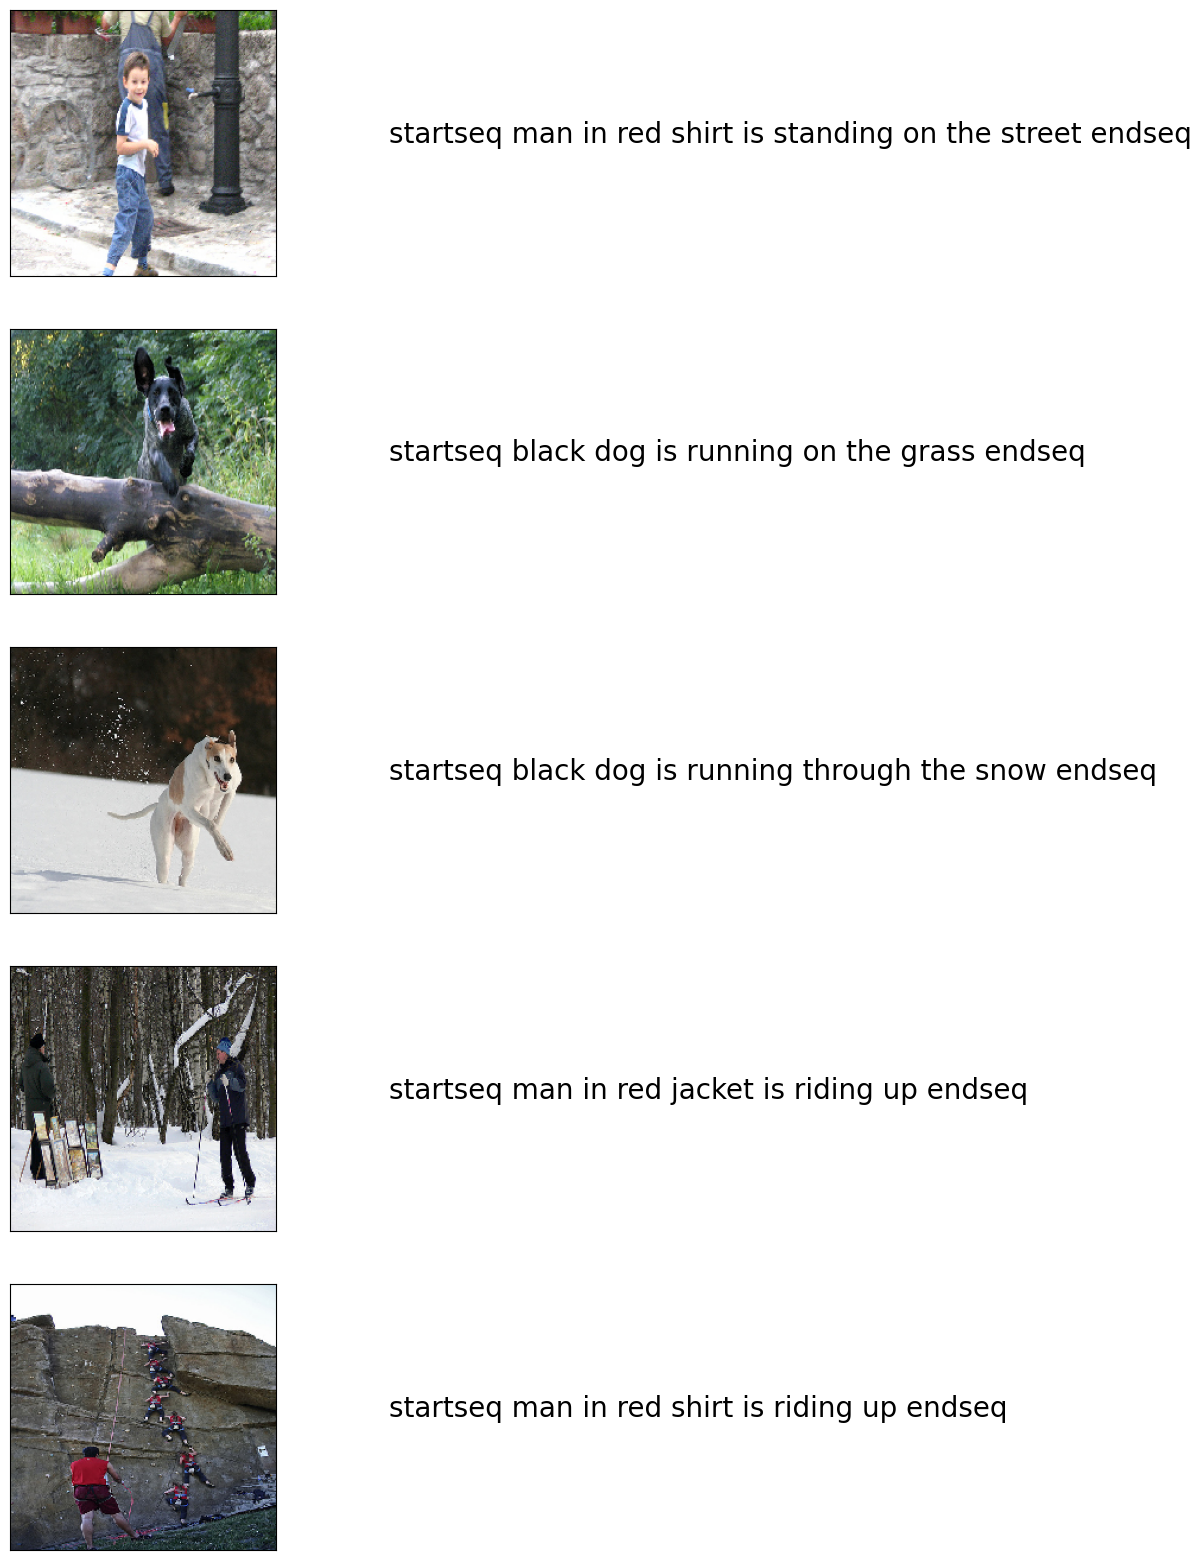

In [58]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model1.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]):
    ## images 
    print(len(image_feature))
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [50]:
import numpy as np
from keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import pad_sequences
import matplotlib.pyplot as plt



index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

# Define the maximum caption length
maxlen = 30

# Define the target image size and load the image
target_size = (224, 224)
image_file = "/content/drive/MyDrive/ImageCaption/Flicker8k_Dataset/1000268201_693b08cb0e.jpg"
image = load_img(image_file, target_size=target_size)

# Preprocess the image using VGG16 preprocessing
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# Generate a caption for the image
in_text = 'startseq'
for iword in range(maxlen):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=maxlen)
    yhat = model.predict([image, sequence], verbose=0)
    yhat = np.argmax(yhat)
    newword = index_word[yhat]
    in_text += " " + newword
    if newword == "endseq":
        break

# Display the image and the generated caption
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(load_img(image_file))
ax.axis('off')
plt.title(in_text, fontsize=12)
plt.show()


TypeError: ignored

In [26]:
from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


In [27]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.007


In [28]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)

Output hidden; open in https://colab.research.google.com to view.